# KOH Posterior Analysis using Mici

In [ ]:
from jax import config
config.update("jax_enable_x64", True)

import arviz
import gpjax as gpx
import jax
import jax.numpy as jnp
import kohgpjax as kgx
from kohgpjax.parameters import (
    ParameterPrior,
    PriorDict,
    ModelParameters,
)
import matplotlib.pyplot as plt
import mici
import numpy as np
import numpyro.distributions as dist

print("GPJax version:", gpx.__version__)
print("KOHGPJax version:", kgx.__version__)
print("JAX Device:", jax.devices())

plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}

GPJax version: 0.11.0
KOHGPJax version: 0.3.1


In [2]:
from data.true_funcs import (
    discrepancy,
    eta,
    TrueParams,
    zeta,
)
TP = TrueParams()

Obviously neither `discrepancy()` nor `zeta()` are known is practice. This is only defined for demonstration purposes.

# The data

In [3]:
DATAFIELD = np.loadtxt('data/obs-a.csv', delimiter=',', dtype=np.float32)
DATACOMP = np.loadtxt('data/sim-a.csv', delimiter=',', dtype=np.float32)

yf = jnp.reshape(DATAFIELD[:, 0], (-1,1)).astype(jnp.float64)
yc = jnp.reshape(DATACOMP[:, 0], (-1,1)).astype(jnp.float64)
xf = jnp.reshape(DATAFIELD[:, 1], (-1, 1)).astype(jnp.float64)
xc = jnp.reshape(DATACOMP[:, 1], (-1,1)).astype(jnp.float64)
tc = jnp.reshape(DATACOMP[:, 2], (-1,1)).astype(jnp.float64)

# normalising the output is not required provided they are all of a similar scale.
# But subtracting the mean is sensible as our GP priors assume zero mean.
ycmean = jnp.mean(yc)
yc_centered = yc - ycmean # Centre so that E[yc] = 0
yf_centered = yf - ycmean

# normalising the inputs is not required provided they are all of a similar scale.

tmin = jnp.min(tc)
tmax = jnp.max(tc)
print(f"tmin: {tmin}, tmax: {tmax}")
tc_normalized = (tc - tmin)/(tmax - tmin) # Normalize to [0, 1]

field_dataset = gpx.Dataset(xf, yf_centered)
comp_dataset = gpx.Dataset(jnp.hstack((xc, tc_normalized)), yc_centered)

kohdataset = kgx.KOHDataset(field_dataset, comp_dataset)
print(kohdataset)

tmin: 0.25823432207107544, tmax: 0.4384155571460724
KOHDataset(
  Datasets:
    Field data = Dataset(Number of observations: 100 - Input dimension: 1),
    Simulation data = Dataset(Number of observations: 500 - Input dimension: 2)
  Attributes:
    No. field observations = 100,
    No. simulation outputs = 500,
    No. variable params = 1,
    No. calibration params = 1,
)


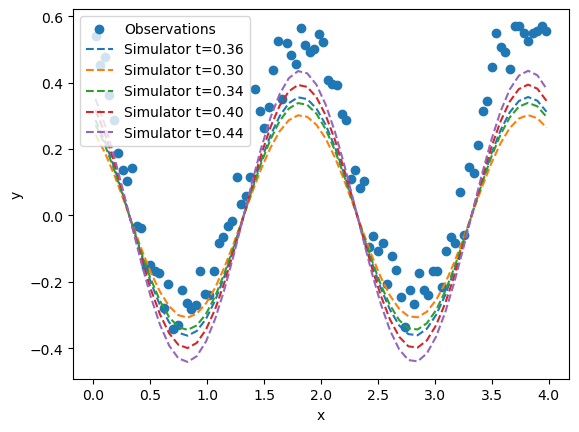

In [4]:
fig, ax = plt.subplots(1, 1)
ax.scatter(xf, yf_centered, label='Observations')
# ax.plot(xf, zeta(xf), label='True function')
rng = np.random.default_rng()
ts = rng.permutation(np.unique(tc))[:5]
for t in ts:
    rows = tc==t
    ax.plot(xc[rows], yc_centered[rows], '--', label=f'Simulator t={t:.2f}')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()

# The Model

In [5]:
class Model(kgx.KOHModel):
    def k_eta(self, params_constrained) -> gpx.kernels.AbstractKernel:
        params = params_constrained['eta']
        return gpx.kernels.ProductKernel(
            kernels=[
                gpx.kernels.RBF(
                    active_dims=[0],
                    lengthscale=jnp.array(params['lengthscales']['x_0']),
                    variance=jnp.array(1/params['variances']['precision'])
                ), 
                gpx.kernels.RBF(
                    active_dims=[1],
                    lengthscale=jnp.array(params['lengthscales']['theta_0']),
                )
            ]
        )
    
    def k_delta(self, params_constrained) -> gpx.kernels.AbstractKernel:
        params = params_constrained['delta']
        return gpx.kernels.RBF(
                active_dims=[0],
                lengthscale=jnp.array(params['lengthscales']['x_0']),
                variance=jnp.array(1/params['variances']['precision'])
            )
    
    def k_epsilon_eta(self, params_constrained) -> gpx.kernels.AbstractKernel:
        params = params_constrained['epsilon_eta']
        return gpx.kernels.White(
                active_dims=[0],
                variance=jnp.array(1/params['variances']['precision'])
            )

In [6]:
# account for the scaling onto [0, 1]
A = (0.25 - tmin)/(tmax - tmin)
B = (0.45 - tmin)/(tmax - tmin)
print(f"A: {A}, B: {B}")
prior_dict: PriorDict = {
    'thetas': {
        'theta_0': ParameterPrior(
            dist.Uniform(low=A, high=B),
            name='theta_0',
        ),
    },
    'eta': {
        'variances': {
                'precision': ParameterPrior(
                dist.Gamma(concentration=2.0, rate=4.0),
                name='eta_precision',
            ),
        },
        'lengthscales': {
            'x_0': ParameterPrior(
                # dist.Gamma(concentration=4.0, rate=1.4),
                dist.LogNormal(loc=0.2, scale=0.6),
                name='eta_lengthscale_x_0',
            ),
            'theta_0': ParameterPrior(
                dist.Gamma(concentration=2.0, rate=3.5),
                name='eta_lengthscale_theta_0',
            ),
        },
    },
    'delta': {
        'variances': {
            'precision': ParameterPrior(
                dist.Gamma(concentration=2.0, rate=0.1),
                name='delta_precision',
            ),
        },
        'lengthscales': {
            'x_0': ParameterPrior(
                # dist.Gamma(concentration=4.0, rate=2.0),
                # dist.LogNormal(loc=0.3, scale=0.7), # slightly longer than eta_lengthscale_x_0
                # dist.LogNormal(loc=0.2, scale=0.4), # Try much smaller
                dist.LogNormal(loc=0.5, scale=1.0), # Try much larger
                name='delta_lengthscale_x_0',
            ),
        },
    },
    'epsilon': { # This is required despite not appearing in the model
        'variances': {
            'precision': ParameterPrior(
                # dist.Gamma(concentration=12.0, rate=0.025),
                dist.LogNormal(loc=6, scale=0.1), # much more concentrated around 400≈exp(6)
                name='epsilon_precision',
            ),
        },
    },
    'epsilon_eta': {
        'variances': {
            'precision': ParameterPrior(
                dist.Gamma(concentration=10.0, rate=0.001),
                name='epsilon_eta_precision',
            ),
        },
    },
}

model_parameters = ModelParameters(
    prior_dict=prior_dict
)

A: -0.04570021993493419, B: 1.0642932814235946


# MCMC Setup

In [7]:
model = Model(
    model_parameters=model_parameters,
    kohdataset=kohdataset,
)

The jax backend here will jit and grad the nlpd function we provide.

In [8]:
##### Mici #####
system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=model.get_KOH_neg_log_pos_dens_func(),
    backend="jax",
)
integrator = mici.integrators.LeapfrogIntegrator(system)

In [9]:
prior_leaves, prior_tree = jax.tree.flatten(prior_dict)
prior_means = jax.tree.map(
    lambda x: x.inverse(x.distribution.mean), prior_leaves
)

init_states = np.array(prior_means) # NOT jnp.array
print(f"Initial states: {init_states}")

Initial states: [ 1.          2.99573227  6.005       9.21034037 -0.55961579  0.38
 -0.69314718  0.        ]


In [10]:
f = model.get_KOH_neg_log_pos_dens_func()
f(init_states)

Array(-1081.15639071, dtype=float64)

# Running MCMC algorithm

First, build the tracer function to get the chains for each parameter. We need to know the ordering of the parameter when jax flattens the pytree. This ordering is easiest obtained if we assign names to the parameters priors. We can simply extract the parameter name and index by iterating through the priors_flat list.

In [11]:
tracer_index_dict = {}
for i, prior in enumerate(model_parameters.priors_flat):
    tracer_index_dict[prior.name] = i
# print(tracer_index_dict)

In [12]:
seed = 1234
n_chain = 2
n_process = 1 # only 1 works on MacOS
n_warm_up_iter = 120
n_main_iter = 80
rng = np.random.default_rng(seed)

##### Mici sampler and adapters #####
# sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=3)
# sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng, max_tree_depth=5)
sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng, max_tree_depth=3)
adapters = [
    mici.adapters.DualAveragingStepSizeAdapter(0.8),
    mici.adapters.OnlineCovarianceMetricAdapter(),
]

def trace_func(state):
    trace = {
        key: state.pos[index] for key, index in tracer_index_dict.items()
    }
    trace['hamiltonian'] = system.h(state)
    return trace

final_states, traces, stats = sampler.sample_chains(
    n_warm_up_iter, 
    n_main_iter, 
    [init_states] * n_chain, 
    adapters=adapters, 
    n_process=n_process, 
    trace_funcs=[trace_func],
    monitor_stats=("n_step", "accept_stat", "step_size", "diverging")
)

Sampling stage: Initial fast adaptive [00:07] > Slow adaptive (1/1) [00:39] > Final fast adaptive [00:04] > Main non-adaptive [00:43]

Chain 1/2: 100%|██████████|80/80 [00:24<00:00, 3.26it/s, n_step=7.00, accept_stat=0.936, step_size=0.416, diverging=0.00]

Chain 2/2: 100%|██████████|80/80 [00:19<00:00, 4.19it/s, n_step=6.90, accept_stat=0.955, step_size=0.416, diverging=0.00]

# Analyse MCMC output

In [13]:
arviz.summary(traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta_lengthscale_x_0,1.801,0.616,0.828,2.916,0.091,0.050,45.0,75.0,1.04
delta_precision,3.041,0.554,2.008,4.012,0.041,0.037,201.0,117.0,1.01
epsilon_eta_precision,12.401,0.064,12.284,12.506,0.005,0.004,189.0,141.0,1.00
epsilon_precision,5.923,0.082,5.775,6.095,0.005,0.006,277.0,144.0,1.01
eta_lengthscale_theta_0,1.377,0.133,1.129,1.609,0.009,0.008,210.0,152.0,1.00
eta_lengthscale_x_0,-0.173,0.058,-0.279,-0.067,0.005,0.005,159.0,114.0,1.03
eta_precision,-0.227,0.396,-1.022,0.444,0.037,0.027,114.0,99.0,1.01
hamiltonian,-2413.031,3.035,-2417.149,-2406.369,0.433,0.214,48.0,98.0,1.03
theta_0,1.354,0.237,0.953,1.767,0.017,0.018,211.0,111.0,1.01


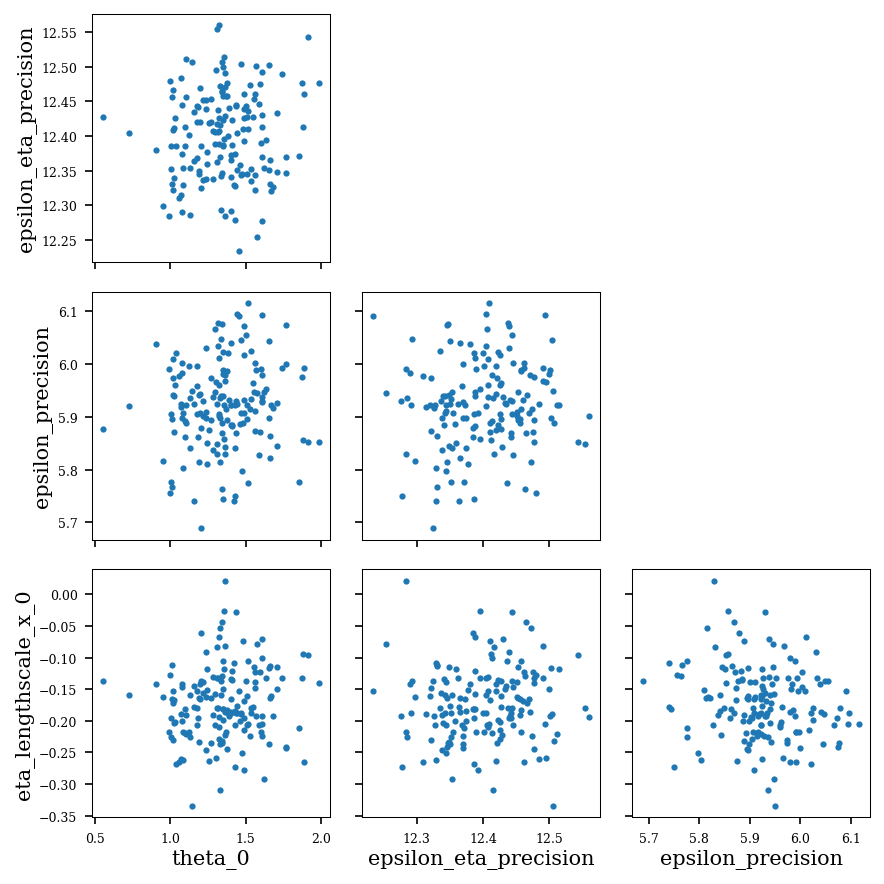

In [16]:
with plt.style.context(plot_style):
    axes = arviz.plot_pair(
        traces,
        var_names=["theta_0", "epsilon_eta_precision", "epsilon_precision", "eta_lengthscale_x_0"],
        figsize=(6, 6)
    )
    axes[0, 0].figure.tight_layout()

# Transform the Chains

In [17]:
traces_transformed = {}
for var, trace in traces.items():
    if var == 'hamiltonian':
        continue
    index = tracer_index_dict[var]
    traces_transformed[var] = model_parameters.priors_flat[index].forward(np.array(trace))
    if var == 'theta_0':
        trace = traces_transformed[var]
        traces_transformed[var] = list((jnp.array(trace) * (tmax - tmin)) + tmin)

params_transformed_flat = {}
for var, trace in traces_transformed.items():
    params_transformed_flat[var] = np.mean(trace) # This operation is valid across chains when each chain has equal length (I think).
    print(var, ": ", np.mean(trace), '±', np.std(trace))

params_transformed = jax.tree.unflatten(
    prior_tree,
    params_transformed_flat.values()
)

delta_lengthscale_x_0 :  7.272522710154132 ± 4.589080998199094
delta_precision :  24.15857575000477 ± 13.268228292174744
epsilon_precision :  374.59539022937486 ± 30.53328850329342
epsilon_eta_precision :  243632.1180624066 ± 15574.902204388913
eta_lengthscale_theta_0 :  3.999021809952831 ± 0.5368678352205539
eta_lengthscale_x_0 :  0.8426088674325618 ± 0.048922946717010855
eta_precision :  0.8597958233609486 ± 0.33462693662077686
theta_0 :  0.4084132250286814 ± 0.007755102542986806


In [18]:
arviz.summary(traces_transformed)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta_lengthscale_x_0,7.273,4.603,0.930,15.932,0.595,0.481,45.0,75.0,1.04
delta_precision,24.159,13.310,4.667,44.372,0.799,1.406,201.0,117.0,1.01
epsilon_eta_precision,243632.118,15623.803,216211.609,270020.277,1116.137,895.685,189.0,141.0,1.00
epsilon_precision,374.595,30.629,311.078,430.790,1.859,2.147,277.0,144.0,1.02
eta_lengthscale_theta_0,3.999,0.539,3.074,4.972,0.037,0.034,210.0,152.0,1.00
eta_lengthscale_x_0,0.843,0.049,0.757,0.935,0.004,0.004,159.0,114.0,1.03
eta_precision,0.860,0.336,0.255,1.435,0.030,0.023,114.0,99.0,1.01
theta_0,0.408,0.008,0.394,0.421,0.001,0.001,211.0,111.0,1.01


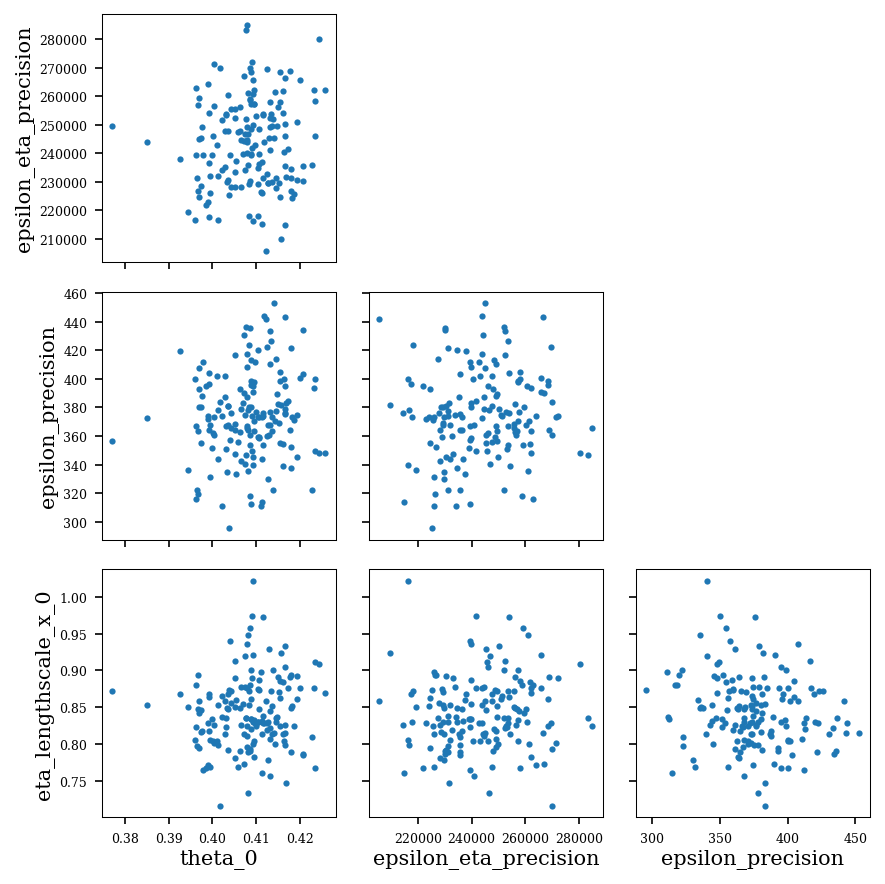

In [19]:
with plt.style.context(plot_style):
    axes = arviz.plot_pair(
        traces_transformed,
        var_names=["theta_0", "epsilon_eta_precision", "epsilon_precision", "eta_lengthscale_x_0"],
        figsize=(6, 6)
    )
    axes[0, 0].figure.tight_layout()

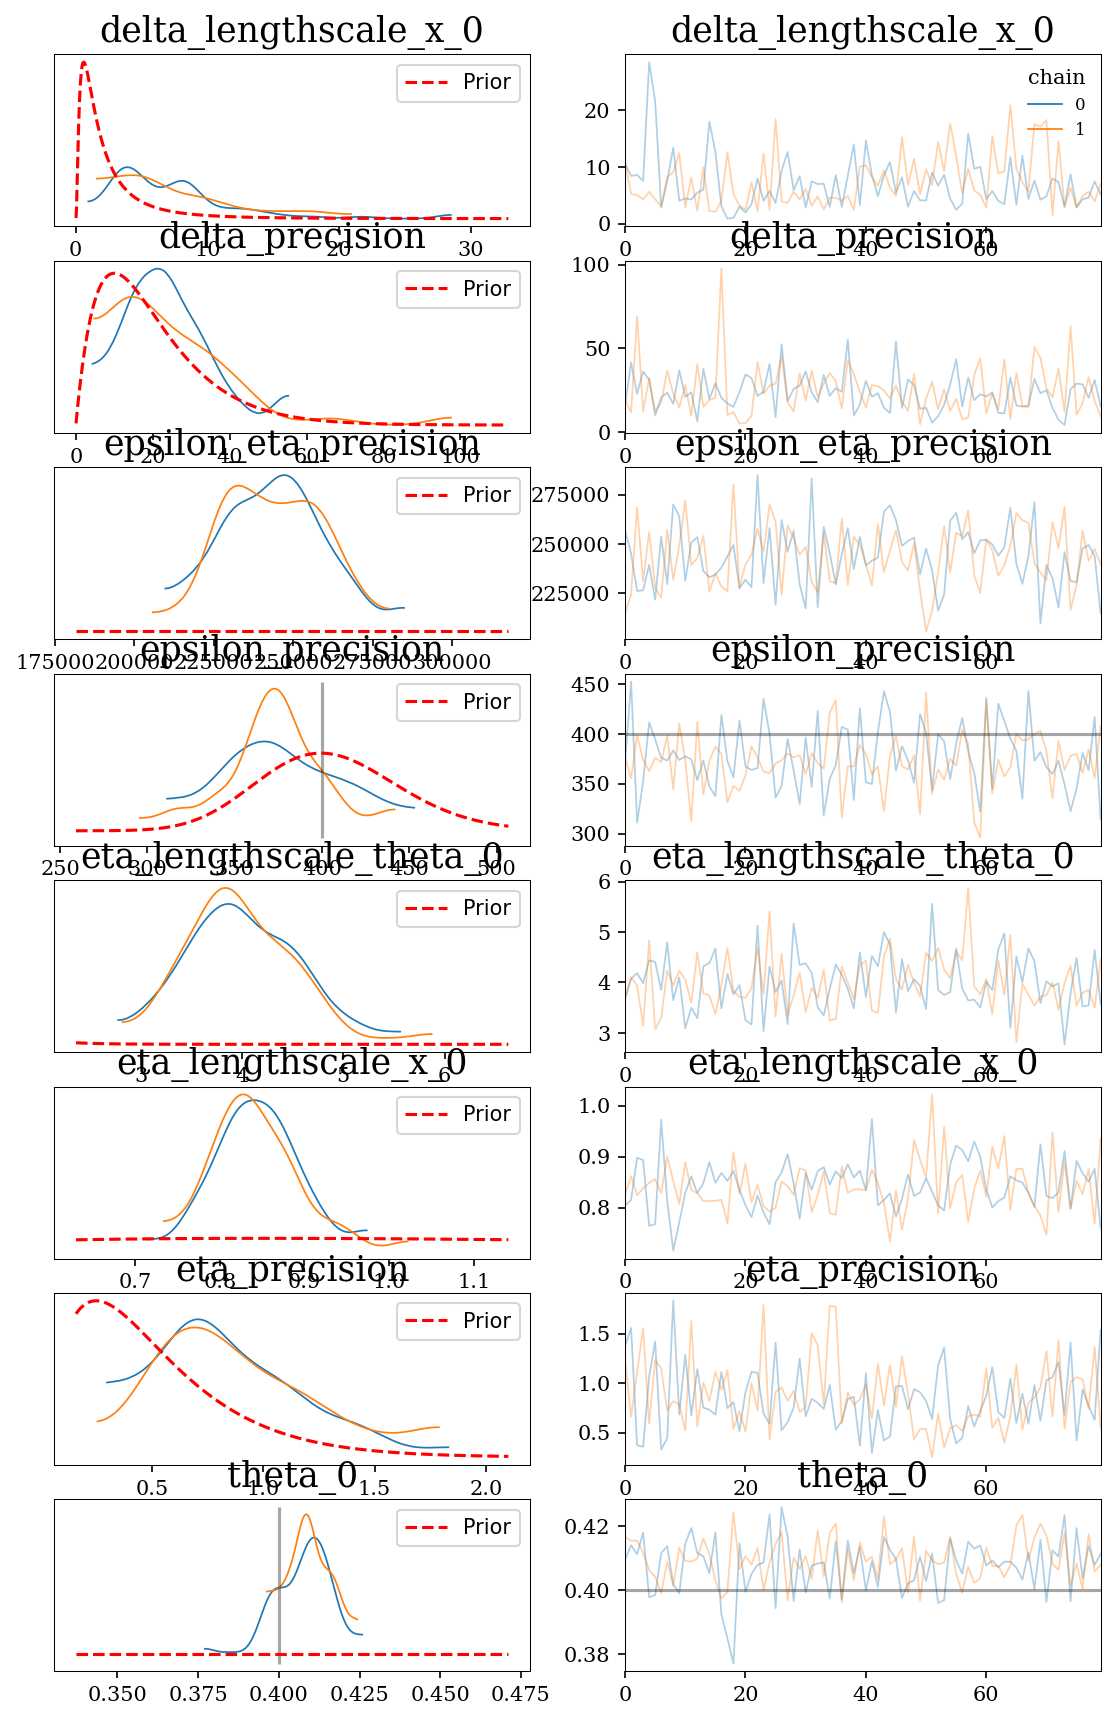

In [20]:
with plt.style.context(plot_style):
    axes = arviz.plot_trace(
        traces_transformed,
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
        lines=(
            ('theta_0', {}, 0.4),
            ('epsilon_precision', {}, 1/TP.obs_var),
        )
    )
for i in range(axes.shape[0]):
    left, right = axes[i, 0].get_xlim()
    left, right = left*0.9, right*1.1
    x = np.linspace(left, right, 1000)
    title = axes[i, 0].get_title()
    prior_dist = model_parameters.priors_flat[tracer_index_dict[title]].distribution
    pdf = jnp.exp(prior_dist.log_prob(x))
    axes[i, 0].plot(x, pdf, color='red', linestyle='--', label='Prior')
    axes[i, 0].legend()
plt.show()
plt.show()

# Analyse posterior fit

## Prediction data

In [21]:
x0_pred = np.linspace(0, 4, 1000)
x1_pred = np.zeros_like(x0_pred)
xpred = np.vstack((x0_pred, x1_pred)).T
print(xpred.shape)

theta = params_transformed_flat['theta_0']#*(tmax - tmin) + tmin
theta_vec = jnp.array([theta, TP.b, TP.c, TP.d, TP.e])
theta_arr = jnp.tile(theta_vec, (xpred.shape[0], 1))
print(theta_arr.shape)

x_test = np.hstack((xpred, theta_arr))
print(x_test.shape)

x_test_GP = x_test[:, [0, 2]]
print(x_test_GP.shape)

dataset = kohdataset.get_dataset(jnp.array(theta).reshape(-1,1))

(1000, 2)
(1000, 5)
(1000, 7)
(1000, 2)


## Posterior GPs

In [22]:
GP_posterior = model.GP_posterior(params_transformed)

eta_pred = GP_posterior.predict_eta(
    x_test_GP,
    dataset
)
zeta_pred = GP_posterior.predict_zeta(
    x_test_GP,
    dataset
)
obs_pred = GP_posterior.predict_obs(
    x_test_GP,
    dataset
)


eta_pred_m = eta_pred.mean + ycmean
eta_pred_v = eta_pred.variance
eta_pred_sd = np.sqrt(eta_pred_v)

zeta_pred_m = zeta_pred.mean + ycmean
zeta_pred_v = zeta_pred.variance
zeta_pred_sd = np.sqrt(zeta_pred_v)

obs_pred_m = obs_pred.mean + ycmean
obs_pred_v = obs_pred.variance
obs_pred_sd = np.sqrt(obs_pred_v)

# x0 = np.linspace(0, 4, 500)
# x1 = np.zeros_like(x0)
# x = np.vstack((x0, x1)).T

## Plot GP modelling simulator

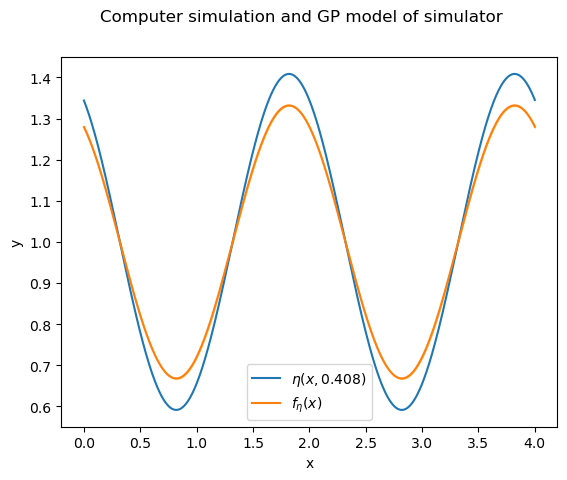

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x_test[:,0], eta(x_test, theta_arr), label=fr'$\eta(x, {theta:.3f})$')
ax.plot(x_test_GP[:,0], eta_pred_m, label=r'$f_\eta(x)$')
ax.fill_between(
    x_test_GP[:,0], 
    eta_pred_m-1.96*eta_pred_sd, 
    eta_pred_m+1.96*eta_pred_sd, 
    alpha=0.5, 
    color='orange'
)
# ax.scatter(obs_x, obs_y, label="observations")

ax.legend()
fig.suptitle("Computer simulation and GP model of simulator")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Plot GP modelling true process

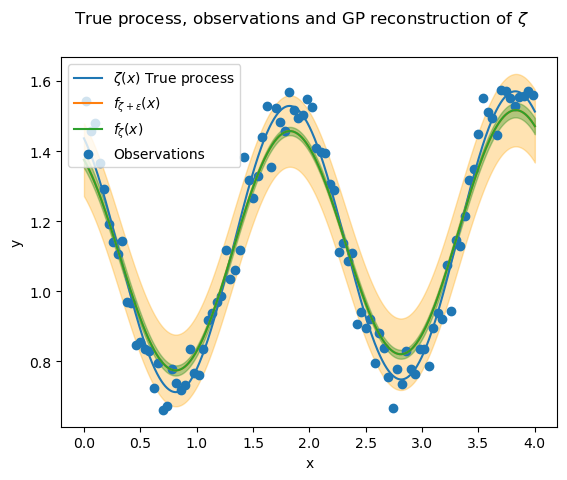

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x_test[:,0], zeta(x_test[:,[0,1]]), label=r'$\zeta(x)$ True process')
ax.plot(x_test_GP[:,0], obs_pred_m, label=r'$f_{\zeta+\epsilon}(x)$')
ax.fill_between(
    x_test_GP[:,0], 
    obs_pred_m-1.96*obs_pred_sd, 
    obs_pred_m+1.96*obs_pred_sd, 
    alpha=0.3, 
    color='orange'
)
ax.plot(x_test_GP[:,0], zeta_pred_m, label=r'$f_{\zeta}(x)$')
ax.fill_between(
    x_test_GP[:,0], 
    zeta_pred_m-1.96*zeta_pred_sd, 
    zeta_pred_m+1.96*zeta_pred_sd, 
    alpha=0.3, 
    color='green'
)
ax.scatter(kohdataset.Xf, kohdataset.z + ycmean, label="Observations")

ax.legend()
fig.suptitle("True process, observations and GP reconstruction of $\zeta$")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Model discrepancy

Interpret the next figure as follows. "True discrepancy" is the actual difference between the functions used to generate the simulation output and the observations. The blue line is the function the code is trying to learn. According to the MCMC samples, $\delta(x)$ should be the blue line. $f_\delta(x)$ is the attempt to learn the blue line.

Notice the uncertainty of the GP is very large and always encompases the true discrepancy function, $0$ for all $x$.

In [25]:
delta_gp_m = zeta_pred_m - eta_pred_m
delta_gp_v = zeta_pred_v + eta_pred_v
delta_gp_sd = np.sqrt(delta_gp_v)

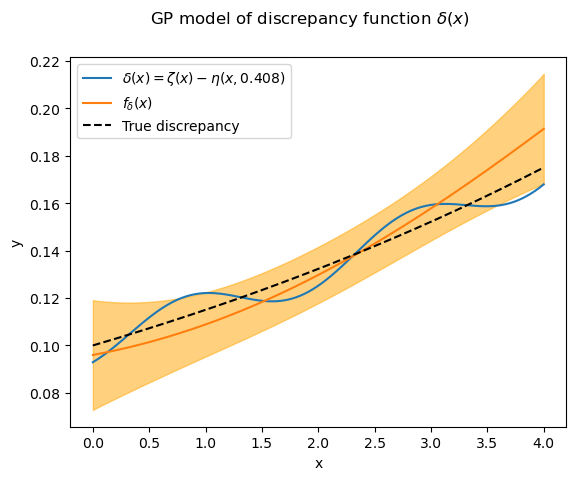

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(x_test[:,0], zeta(x_test[:,[0,1]]) - eta(x_test, theta_arr), label=rf'$\delta(x) = \zeta(x) - \eta(x, {theta:.3f})$')
ax.plot(x_test_GP[:,0], delta_gp_m, label=r'$f_\delta(x)$')
ax.fill_between(
    x_test_GP[:,0], 
    delta_gp_m-1.96*delta_gp_sd, 
    delta_gp_m+1.96*delta_gp_sd, 
    alpha=0.5, 
    color='orange'
)
ax.plot(x_test[:,0], discrepancy(x_test[:,[0,1]]), color='black', linestyle='--', label='True discrepancy')

ax.legend()
fig.suptitle("GP model of discrepancy function $\delta(x)$")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()